In [1]:
from mica_text_coref.coref.movie_coref import data

import collections
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel

plt.rcParams.update({"font.size": 14,
                     "font.family": "sans-serif",
                     "figure.figsize": (15, 6),
                     "axes.facecolor": "212121",
                     "figure.dpi"       : 200,
                     "legend.fontsize"  : "medium",
                     "figure.titlesize" : "medium",
                     "lines.linewidth": 2,
})

In [2]:
def functionals(arr: np.ndarray) -> list[float]:
  mean = np.mean(arr)
  min = np.min(arr)
  max = np.max(arr)
  std = np.std(arr)
  median = np.median(arr)
  quantile75 = np.quantile(arr, 0.75)
  quantile90 = np.quantile(arr, 0.90)
  quantile95 = np.quantile(arr, 0.95)
  return [mean, std, min, max, median, quantile75, quantile90, quantile95]

def print_functionals(arr, desc):
  arr = np.array(arr)
  mean, std, min, max, med, q75, q90, q95 = functionals(arr)
  print(f"{desc}:")
  print(f"\t{'Mean +- std':20s}    = {mean:.2f} +- {std:.2f}")
  print(f"\t{'[Min, Max]':20s}    = [{min}, {max}]")
  print(f"\tquantiles: 50% (median) = {med:.2f}, 75% = {q75:.2f}, "
        f"90% = {q90:.2f}, 95% = {q95:.2f}")
  print()

def draw_histogram(arr, var="x", bins=10, disable_bar_labels=False, 
                   return_histogram=False, **kwargs):
  narr, bins, patches = plt.hist(arr, bins=bins, color="c", **kwargs)
  plt.xlabel(var)
  plt.ylabel("frequency")
  plt.title(f"Histogram of {var}")
  s = len(arr)

  if not disable_bar_labels:
    for i in range(len(patches)):
      xx = patches[i].get_x()
      height = patches[i].get_height()
      width = patches[i].get_width()
      text = f"[{bins[i]:.1f}, {bins[i + 1]:.1f})"
      if i == len(patches) - 1:
        text = f"[{bins[i]:.0f}, {bins[i + 1]:.0f}]"
      plt.text(xx + width/2, height, text, ha="center", va="bottom", 
              fontsize=12, color="w")
      plt.text(xx + width/2, height, f"{100*height/s:.1f}%", ha="center",
              va="top", fontsize=8, color="k")
  
  plt.show()

  if return_histogram:
    return narr, bins, patches

def describe(arr, desc, q=1, **kwargs):
  x = np.array(arr)
  x = x[x < np.quantile(x, q)]
  desc = f"{desc} ({q})" if q < 1 else desc
  print_functionals(x, desc)
  return draw_histogram(x, var=desc, **kwargs)

In [3]:
roberta_fast_tokenizer = AutoTokenizer.from_pretrained(
    "roberta-large", use_fast=True)

In [4]:
regular_corpus = data.CorefCorpus("/home/sbaruah_usc_edu/mica_text_coref/data/"
                                  "movie_coref/results/regular/movie.jsonlines")
addsays_corpus = data.CorefCorpus("/home/sbaruah_usc_edu/mica_text_coref/data/"
                                  "movie_coref/results/addsays/movie.jsonlines")
nocharc_corpus = data.CorefCorpus("/home/sbaruah_usc_edu/mica_text_coref/data/"
                                  "movie_coref/results/nocharacters/movie.jsonlines")
regular_cr_corpus = data.CharacterRecognitionDataset(
    regular_corpus, roberta_fast_tokenizer, seq_length=256,
    obey_scene_boundaries=True, label_type="head")
regular_cr_corpus_disobey_scene = data.CharacterRecognitionDataset(
    regular_corpus, roberta_fast_tokenizer, seq_length=256,
    obey_scene_boundaries=False, label_type="head")

In [6]:
set(regular_cr_corpus.parse_tag_to_id.values())

{0, 1, 2, 3, 4, 5}

In [5]:
total_n_tokens = 0
for document in regular_corpus:
    print(f"{document.movie} {len(document.token)}")
    total_n_tokens += len(document.token)
print(f"Total number of tokens = {total_n_tokens}")

avengers_endgame 35816
dead_poets_society 26200
john_wick 24954
prestige 35910
quiet_place 27843
zootopia 27127
shawshank 8090
bourne 8087
basterds 7777
Total number of tokens = 201804


In [6]:
def consolidate_tags(tags: list[str]) -> list[str]:
    new_tags = []
    i = 0
    while i < len(tags):
        j = i + 1
        while j < len(tags) and tags[j] == tags[i]:
            j += 1
        new_tags.append(tags[i])
        i = j
    return new_tags

In [7]:
def n_token_distribution(cr_corpus):
    n_tokens_list = []
    n_subtokens_list = []
    parse_id_to_tag = {0:"O", 1:"S", 2:"N", 3:"C", 4:"D", 5:"E"}

    for subtoken_ids, attn_mask, token_offset, parse_tag_ids, label_ids in (
        cr_corpus):
        n_subtokens = attn_mask.sum().item()
        nz = torch.nonzero((token_offset[:,0] == token_offset[:,1]) &
                        (token_offset[:,0] == 0))
        n_tokens = len(token_offset) if nz.nelement() == 0 else nz[0][0].item() + 1
        parse_tags = [parse_id_to_tag[tag_id.item()] for tag_id in parse_tag_ids]
        parse_tags_text = "".join(consolidate_tags(parse_tags))
        n_tokens_list.append(n_tokens)
        n_subtokens_list.append(n_subtokens)
    
    print(sum(n_tokens_list))
    print(collections.Counter(n_tokens_list))
    describe(n_tokens_list, "#tokens/sequence")

201813
Counter({256: 783, 233: 1, 89: 1, 123: 1, 71: 1, 196: 1, 248: 1, 155: 1, 152: 1, 98: 1})
#tokens/sequence:
	Mean +- std             = 151.67 +- 59.64
	[Min, Max]              = [71, 248]
	quantiles: 50% (median) = 152.00, 75% = 196.00, 90% = 236.00, 95% = 242.00



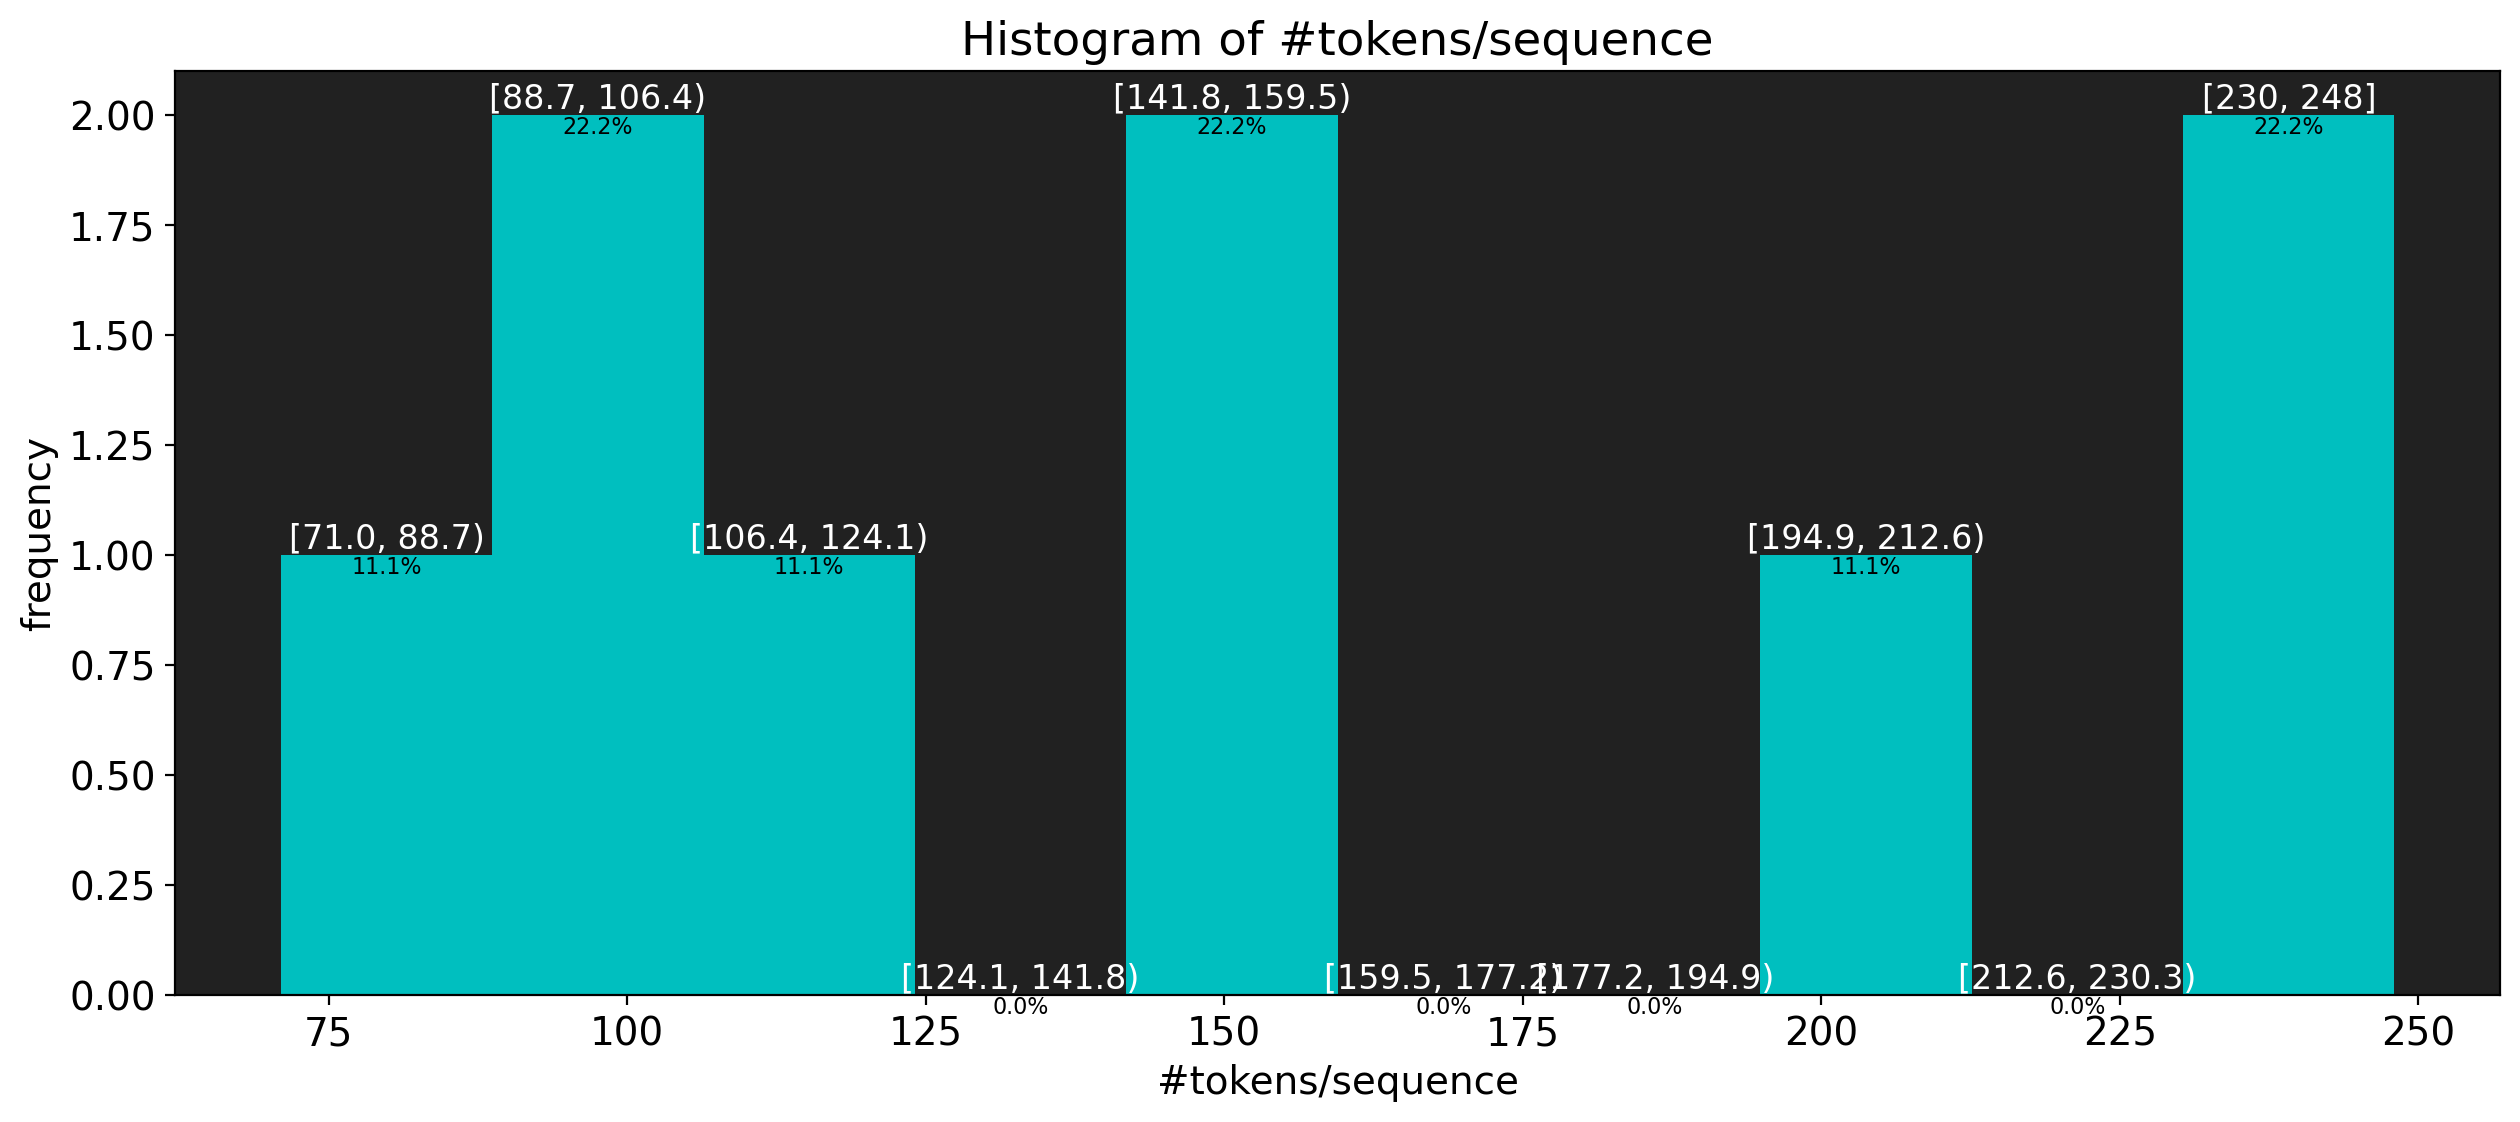

In [8]:
n_token_distribution(regular_cr_corpus_disobey_scene)

In [10]:
dataloader = DataLoader(regular_cr_corpus_disobey_scene, batch_size=8,
                        shuffle=True)
device = torch.device("cuda:0")

In [11]:
for batch_input in dataloader:
    (batch_subtoken_ids, batch_attention_mask, batch_token_offset,
     batch_parse_ids, batch_labels) = batch_input
    batch_subtoken_ids = batch_subtoken_ids.to(device)
    batch_attention_mask = batch_attention_mask.to(device)
    batch_token_offset = batch_token_offset.to(device)
    batch_parse_ids = batch_parse_ids.to(device)
    batch_labels = batch_labels.to(device)
    print(f"subtoken_ids = {batch_subtoken_ids.dtype} {batch_subtoken_ids.shape}")
    print(f"attention_mask = {batch_attention_mask.dtype} {batch_attention_mask.shape}")
    print(f"token_offset = {batch_token_offset.dtype} {batch_token_offset.shape}")
    print(f"parse_ids = {batch_parse_ids.dtype} {batch_parse_ids.shape}")
    print(f"labels = {batch_labels.dtype} {batch_labels.shape}")
    break

subtoken_ids = torch.int64 torch.Size([8, 439])
attention_mask = torch.int64 torch.Size([8, 439])
token_offset = torch.int64 torch.Size([8, 256, 2])
parse_ids = torch.int64 torch.Size([8, 256])
labels = torch.int64 torch.Size([8, 256])


In [12]:
batch_size = len(batch_subtoken_ids)
print(f"batch_size = {batch_size}")

batch_size = 8


In [13]:
text_encoder = AutoModel.from_pretrained("roberta-large")
subtoken_net = nn.Linear(text_encoder.config.hidden_size, 1)
text_encoder.to(device)
subtoken_net.to(device)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Linear(in_features=1024, out_features=1, bias=True)

In [14]:
# subtoken_embedding = batch_size x max_n_subtokens x encoder_hidden_size
encoder_output = text_encoder(batch_subtoken_ids, batch_attention_mask)
subtoken_embedding = encoder_output.last_hidden_state
print(f"subtoken_embedding = {subtoken_embedding.dtype} {subtoken_embedding.shape}")

subtoken_embedding = torch.float32 torch.Size([8, 439, 1024])


In [15]:
encoder_hidden_size = text_encoder.config.hidden_size
_subtoken_embedding = subtoken_embedding.view(-1, encoder_hidden_size)
print(f"_subtoken_embedding = {_subtoken_embedding.dtype} {_subtoken_embedding.shape}")

_subtoken_embedding = torch.float32 torch.Size([3512, 1024])


In [16]:
_token_offset = batch_token_offset.view(-1, 2)
print(f"_token_offset = {_token_offset.dtype} {_token_offset.shape}")

_token_offset = torch.int64 torch.Size([2048, 2])


In [17]:
n_subtokens, n_tokens = len(_subtoken_embedding), len(_token_offset)
token_begin, token_end = _token_offset[:,0], _token_offset[:,1]
print(f"n_subtokens = {n_subtokens}, n_tokens = {n_tokens}")
print(f"token_begin = {token_begin.dtype} {token_begin.shape}")
print(f"token_end   = {token_end.dtype} {token_end.shape}")

n_subtokens = 3512, n_tokens = 2048
token_begin = torch.int64 torch.Size([2048])
token_end   = torch.int64 torch.Size([2048])


In [18]:
attn_mask = torch.arange(0, n_subtokens, device=device).expand(
            (n_tokens, n_subtokens))
print(f"attn_mask = {attn_mask.dtype} {attn_mask.shape}")

attn_mask = torch.int64 torch.Size([2048, 3512])


In [19]:
attn_mask = ((attn_mask >= token_begin.unsqueeze(1)) * 
             (attn_mask <= token_end.unsqueeze(1)))
attn_mask = torch.log(attn_mask.to(torch.float))

In [20]:
print(attn_mask)

tensor([[-inf, 0., 0.,  ..., -inf, -inf, -inf],
        [-inf, -inf, -inf,  ..., -inf, -inf, -inf],
        [-inf, -inf, -inf,  ..., -inf, -inf, -inf],
        ...,
        [-inf, -inf, -inf,  ..., -inf, -inf, -inf],
        [-inf, -inf, -inf,  ..., -inf, -inf, -inf],
        [-inf, -inf, -inf,  ..., -inf, -inf, -inf]], device='cuda:0')


In [21]:
attn_scores = subtoken_net(_subtoken_embedding).T
print(f"attn_scores = {attn_scores.dtype} {attn_scores.shape}")

attn_scores = torch.float32 torch.Size([1, 3512])


In [22]:
attn_scores = attn_scores.expand((n_tokens, n_subtokens))
print(f"attn_scores = {attn_scores.dtype} {attn_scores.shape}")

attn_scores = torch.float32 torch.Size([2048, 3512])


In [23]:
attn_scores = attn_mask + attn_scores
del attn_mask
print(attn_scores)

tensor([[   -inf, -0.2143, -0.0813,  ...,    -inf,    -inf,    -inf],
        [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
        [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
        ...,
        [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
        [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf],
        [   -inf,    -inf,    -inf,  ...,    -inf,    -inf,    -inf]],
       device='cuda:0', grad_fn=<AddBackward0>)


In [24]:
subtoken_attn = torch.softmax(attn_scores, dim=1)
print(f"subtoken_attn = {subtoken_attn.dtype} {subtoken_attn.shape}")
print(subtoken_attn)

subtoken_attn = torch.float32 torch.Size([2048, 3512])
tensor([[0.0000, 0.4668, 0.5332,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [25]:
token_embedding = torch.mm(
            subtoken_attn, _subtoken_embedding).reshape(
                batch_size, -1, encoder_hidden_size)
print(f"token_embedding = {token_embedding.dtype} {token_embedding.shape}")

token_embedding = torch.float32 torch.Size([8, 256, 1024])


In [26]:
parse_embedding = nn.Embedding(6, 50)
parse_embedding.to(device)

Embedding(6, 50)

In [28]:
parse_input = parse_embedding(batch_parse_ids)
gru_input = torch.cat((token_embedding, parse_input), dim=2).contiguous()
print(f"gru_input = {gru_input.dtype} {gru_input.shape}")

gru_input = torch.float32 torch.Size([8, 256, 1074])


In [29]:
gru = nn.GRU(encoder_hidden_size + 50, 256)
gru.to(device)

GRU(1074, 256)

In [30]:
output_net = nn.Linear(256, 2)
output_net.to(device)

Linear(in_features=256, out_features=2, bias=True)

In [31]:
gru_output, _ = gru(gru_input)
logits = output_net(gru_output)
print(f"logits = {logits.dtype} {logits.shape}")

logits = torch.float32 torch.Size([8, 256, 2])


In [33]:
token_attention_mask = torch.any(subtoken_attn > 0, dim=1).reshape(
                batch_size, -1)
print(f"token_attention_mask = {token_attention_mask.dtype} {token_attention_mask.shape}")

token_attention_mask = torch.bool torch.Size([8, 256])


In [35]:
def compute_loss(
    logits: torch.FloatTensor, label_ids: torch.LongTensor,
    attn_mask: torch.FloatTensor, n_labels: int) -> torch.FloatTensor:
    """Compute cross entropy loss"""
    active_labels = label_ids[attn_mask == 1.]
    active_logits = logits.flatten(0, 1)[attn_mask.flatten() == 1.]
    label_distribution = torch.bincount(active_labels,
        minlength=n_labels)
    class_weight = torch.sqrt(len(active_labels)/(1 + label_distribution))
    cross_entrop_loss_fn = nn.CrossEntropyLoss(weight=class_weight, 
        reduction="mean")
    loss = cross_entrop_loss_fn(active_logits, active_labels)
    return loss

In [36]:
loss = compute_loss(logits, batch_labels, token_attention_mask, 2)

In [37]:
loss.backward()